# 動力学モデル
## チャネル動態の動力学的表現
指数関数型シナプスとモデルの振る舞いはほぼ同一だが, 式の構成が少し異なるモデルとして**動力学モデル** (Kinetic model, またはMarkov kinetic model)がある {cite:p}`Destexhe1994-ro`．動力学モデルはHHモデルのゲート変数の式と類似した式で表される．このモデルではチャネルが開いた状態(Open)と閉じた状態(Close), および神経伝達物質(neurotransmitter)の放出状態(T)の2つの要素に関する状態がある．また, 閉$\to$開の反応速度を$\alpha$, 開$\to$閉の反応速度を$\beta$とする．このとき，これらを表す状態遷移の式は次のようになる．

$$
\begin{equation}
\text{Close}+\text{T}  \underset{\beta}{\overset{\alpha}{\rightleftharpoons}}\text{Open}    
\end{equation}
$$

ここで, シナプス動態を$r$とすると

$$
\begin{equation}
\frac{dr}{dt}=\alpha T (1-r) - \beta r
\end{equation}
$$

となる．ただし, Tはシナプス前細胞が発火したときにインパルス的に1だけ増加するとする．また, $\alpha, \beta$は速度なので, 時定数の逆数であることに注意しよう． $\alpha=2000 \text{ms}^{-1}$, $\beta=200 \text{ms}^{-1}$とすると, シナプス動態は次のようになる．

In [1]:
using PyPlot
rc("axes.spines", top=false, right=false)

In [2]:
dt = 1e-4 # タイムステップ (sec)
α, β = 1/5e-4, 1/5e-3
T = 0.05 # シミュレーション時間 (sec)
nt = Int(T/dt) # シミュレーションの総ステップ

r = zeros(nt)

for t in 1:nt-1
    spike = ifelse(t == 1, 1, 0)
    r[t+1] = r[t] + dt * (α*spike*(1-r[t]) - β*r[t])
end

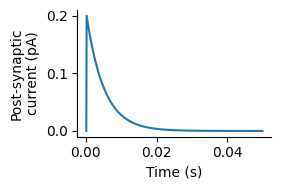

In [3]:
time = (1:nt)*dt
fig, ax = subplots(figsize=(3, 2))
ax.plot(time, r)
ax.set_xlabel("Time (s)"); ax.set_ylabel("Post-synaptic\ncurrent (pA)")
fig.tight_layout()

## Hodgkin-Huxleyモデルにおけるシナプスモデル
これまで明示的にスパイクの発生が表現されたモデルを用いてきたが，HHモデルでは単なる膜電位の変数があるのみである．ここでは前述した動力学的モデルを用いてHHモデルにおけるシナプス動態の記述を行う \citep{Destexhe1994-ro,Batista2014-ax}．

$r_{j}$を$j$番目のニューロンのpre-synaptic dynamicsとすると，$r_{j}$は次式に従う．

$$
\begin{equation}
\frac{\mathrm{d} r_{j}}{\mathrm{d} t}=\left(\frac{1}{\tau_{r}}-\frac{1}{\tau_{d}}\right) \frac{1-r_{j}}{1+\exp \left(-V_{j}+V_{0}\right)}-\frac{r_{j}}{\tau_{d}}
\end{equation}
$$

ただし，時定数 $\tau_r=0.5, \tau_d = 8$ (ms), 反転電位 $V_0 = -20$ (mV)とする．前節で既に$r$の描画は行ったが，パルス波を印加した場合の挙動を確認する．

In [4]:
using Parameters: @unpack # or using UnPack

abstract type Layer end
abstract type Neuron <: Layer end
abstract type SpikeNeuron <: Neuron end

abstract type Synapse <: Layer end

@kwdef struct HHParameter{FT}
    Cm::FT = 1 # 膜容量(uF/cm^2)
    gNa::FT = 120; gK::FT = 36; gL::FT = 0.3 # Na+, K+, leakの最大コンダクタンス(mS/cm^2)
    ENa::FT = 50; EK::FT = -77; EL::FT = -54 # Na+, K+, leakの平衡電位(mV)
end

@kwdef mutable struct HH{FT} <: SpikeNeuron
    num_neurons::UInt16
    dt::FT = 1e-3
    param::HHParameter = HHParameter{FT}()
    v::Vector{FT} = fill(-65, num_neurons)
    m::Vector{FT} = fill(0.05, num_neurons) 
    h::Vector{FT} = fill(0.6, num_neurons)
    n::Vector{FT} = fill(0.32, num_neurons)
end

@kwdef struct HHKineticSynapseParameter{FT}
    tr::FT = 0.5; td::FT = 8 # ms
    tr⁻¹::FT = 1/tr; td⁻¹::FT = 1/td
    v₀::FT = -20 # mV
end

@kwdef mutable struct HHKineticSynapse{FT} <: Synapse
    num_neurons::UInt16
    dt::FT = 1e-3
    param::HHKineticSynapseParameter = HHKineticSynapseParameter{FT}()
    r::Vector{FT} = zeros(num_neurons)
end

function update!(neuron::HH, x::Vector)
    @unpack num_neurons, dt, v, m, h, n = neuron
    @unpack Cm, gNa, gK, gL, ENa, EK, EL = neuron.param
    @inbounds for i = 1:num_neurons
        m[i] += dt * ((0.1(v[i]+40)/(1 - exp(-0.1(v[i]+40))))*(1 - m[i]) - 4exp(-(v[i]+65) / 18)*m[i])
        h[i] += dt * ((0.07exp(-0.05(v[i]+65)))*(1 - h[i]) - 1/(1 + exp(-0.1(v[i]+35)))*h[i])
        n[i] += dt * ((0.01(v[i]+55)/(1 - exp(-0.1(v[i]+55))))*(1 - n[i]) - (0.125exp(-0.0125(v[i]+65)))*n[i])
        v[i] += dt / Cm * (x[i] - gNa * m[i]^3 * h[i] * (v[i] - ENa) - gK * n[i]^4 * (v[i] - EK) - gL * (v[i] - EL))
    end
    return v
end

function update!(synapse::HHKineticSynapse, v::Vector)
    @unpack num_neurons, dt, r = synapse
    @unpack tr⁻¹, td⁻¹, v₀ = synapse.param    
    @inbounds for i = 1:num_neurons
        r[i] += dt * ((tr⁻¹ - td⁻¹) * (1 - r[i])/(1 + exp(-v[i] + v₀)) - r[i] * td⁻¹)
    end
    return r
end

(layer::Layer)(x) = update!(layer, x)

シミュレーションを実行する．

In [5]:
T = 50 # ms
dt = 0.01f0 # ms
nt = Int32(T/dt) # number of timesteps
num_neurons = 1 # ニューロンの数

# 入力刺激
time = Array{Float32}(1:nt)*dt
Ie = repeat(5*((time .> 10) - (time .> 15)), 1, num_neurons)  # injection current

# 記録用
varr, rarr = zeros(Float32, nt, num_neurons), zeros(Float32, nt, num_neurons)

# modelの定義
hh_neurons = HH{Float32}(num_neurons=num_neurons, dt=dt)
hh_synapse = HHKineticSynapse{Float32}(num_neurons=num_neurons, dt=dt)

# simulation
@time for t = 1:nt
    v = hh_neurons(Ie[t, :])
    r = hh_synapse(v)
    varr[t, :], rarr[t, :] = v, r
end

  0.130478 seconds (442.70 k allocations: 14.794 MiB, 92.79% compilation time)


結果を描画する．

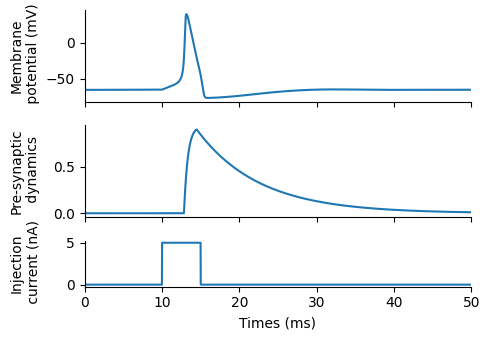

In [15]:
fig, axes = subplots(3, 1, figsize=(5,3.5), sharex="all", height_ratios=[2, 2, 1])
axes[1].plot(time, varr[:, 1]); axes[1].set_ylabel("Membrane\n potential (mV)"); axes[1].set_xlim(0, 50)
axes[2].plot(time, rarr[:, 1]); axes[2].set_ylabel("Pre-synaptic\n dynamics")
axes[3].plot(time, Ie[:, 1]); axes[3].set_xlabel("Times (ms)"); axes[3].set_ylabel("Injection\n current (nA)")
fig.align_labels()
fig.tight_layout()

## 参考文献
```{bibliography}
:filter: docname in docnames
```